In [2]:
import json
import numpy as np

import keras

C:\Users\sanat\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Importing keras libraries and packages

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks

## Importing images for training

In [4]:
with open('D:/Projects/New folder/shipsnet.json', 'r') as f:
    d = json.load(f)
    data, labels, locations, scene_ids = d['data'], d['labels'], d['locations'], d['scene_ids']

In [5]:
x = np.array(data).astype('uint8').reshape((-1, 3, 80, 80)) # 3 channels, 80x80 pixels
y = np.array(labels).astype('uint8')

### flip each x[i] from [layer][row][col] to [row][col][layer]

In [6]:
x = x.transpose([0,2,3,1])

### normalize pixel values to [0, 1]

In [7]:
x = x / 255

### turn y boolean values into categorical values (i.e. [p_notship, p_ship] vectors)

In [8]:
y = keras.utils.np_utils.to_categorical(y)

### expand training data by rotating and flipping

In [9]:
x_prime = np.concatenate((
    x,
    np.rot90(x, 1, (1,2)),
    np.rot90(x, 2, (1,2)),
    np.rot90(x, 3, (1,2)),
    np.flip(x, 1),
    np.flip(x, 1)
    ))

y_prime = np.concatenate((y, y, y, y, y, y))

## Convolution neural network

In [10]:
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D

model = keras.models.Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(80, 80, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (9,9), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (9,9), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

## Training the network

In [11]:
history = model.fit(x_prime, y_prime, epochs=12, validation_split=0.2, shuffle=True)

Train on 17280 samples, validate on 4320 samples
Epoch 1/12
17280/17280 [==============================] - 250s 14ms/step - loss: 0.3922 - acc: 0.8241 - val_loss: 0.3614 - val_acc: 0.8544
Epoch 2/12
17280/17280 [==============================] - 229s 13ms/step - loss: 0.2424 - acc: 0.8942 - val_loss: 0.2408 - val_acc: 0.9072
Epoch 3/12
17280/17280 [==============================] - 227s 13ms/step - loss: 0.1893 - acc: 0.9189 - val_loss: 0.1933 - val_acc: 0.9269
Epoch 4/12
17280/17280 [==============================] - 223s 13ms/step - loss: 0.1588 - acc: 0.9344 - val_loss: 0.1840 - val_acc: 0.9303
Epoch 5/12
17280/17280 [==============================] - 229s 13ms/step - loss: 0.1323 - acc: 0.9477 - val_loss: 0.1715 - val_acc: 0.9375
Epoch 6/12
17280/17280 [==============================] - 228s 13ms/step - loss: 0.1103 - acc: 0.9571 - val_loss: 0.1560 - val_acc: 0.9412
Epoch 7/12
17280/17280 [==============================] - 229s 13ms/step - loss: 0.0980 - acc: 0.9631 - val_loss: 0.1

## Visualizing model accuracy and loss

In [12]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15,5))

left = fig.add_subplot(1, 2, 1)
right = fig.add_subplot(1, 2, 2)

left.plot(history.history['acc'])
left.plot(history.history['val_acc'])
left.set_title('model accuracy')
left.set_ylabel('accuracy')
left.set_xlabel('epoch')
left.legend(['train', 'test'], loc='lower right')

right.plot(history.history['loss'])
right.plot(history.history['val_loss'])
right.set_title('model loss')
right.set_ylabel('loss')
right.set_xlabel('epoch')
right.legend(['train', 'test'], loc='upper right')

plt.show()

<Figure size 1500x500 with 2 Axes>

## Importing image to seach ships in

In [13]:
import PIL

scene = PIL.Image.open('D:/Projects/New folder/sfbay_1.png')
tensor = np.array(scene).astype('uint8') / 255

In [18]:
width, height = scene.size
STEP_SIZE = 10

ships = {}

for row in range(0, height, STEP_SIZE):
    for col in range(0, width, STEP_SIZE):
        area = tensor[row:row+80, col:col+80, 0:3]
        
        if area.shape != (80, 80, 3):
            continue
            
        prediction = model.predict(np.array([area]))
        score = prediction[0][1]
        
        if score > 0.5:
            print("found ship at " + str([row,col]) + "with score " + str(score))
            ships[row, col] = score

found ship at[50, 1150]with score0.71366554
found ship at[410, 1640]with score0.9495894
found ship at[420, 1640]with score0.9460446
found ship at[420, 1890]with score0.6157044
found ship at[430, 1890]with score0.87348324
found ship at[440, 1630]with score0.7649405
found ship at[440, 1890]with score0.8472546
found ship at[450, 1630]with score0.8669204
found ship at[460, 2190]with score0.8105367
found ship at[470, 2190]with score0.99996173
found ship at[480, 2190]with score0.5621781
found ship at[490, 1560]with score0.902569
found ship at[500, 1560]with score0.7880725
found ship at[690, 950]with score0.64975244
found ship at[700, 950]with score0.688787
found ship at[710, 950]with score0.5129668
found ship at[740, 950]with score0.53567094
found ship at[800, 1010]with score0.6377765
found ship at[820, 1010]with score0.58963025
found ship at[850, 2000]with score0.5607746
found ship at[920, 1720]with score0.84616077
found ship at[930, 1720]with score0.58350855
found ship at[1170, 1830]with s

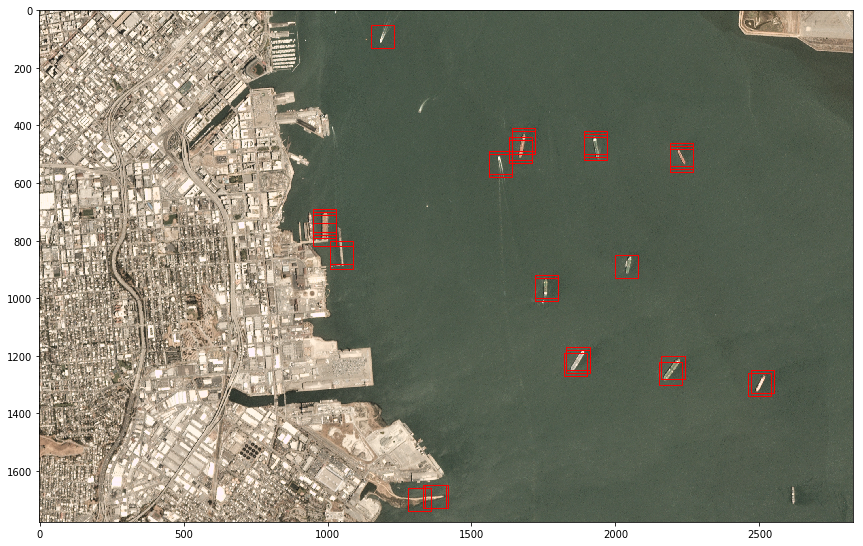

In [19]:
from matplotlib import pyplot as plt
from matplotlib import patches

fig = plt.figure(figsize=(16,32))
ax = fig.add_subplot(3, 1, 1)

ax.imshow(tensor)

for ship in ships:
    row, col = ship
    ax.add_patch(patches.Rectangle((col, row), 80, 80, edgecolor='r', facecolor='none'))

plt.show()